In [6]:
#! /usr/bin/env python3

# data libraries
import sys
import os
import datetime as dt  # Python standard library datetime  module
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
from netCDF4 import Dataset,num2date  # http://code.google.com/p/netcdf4-python/
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.style as style
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point 
import cartopy.mpl.ticker as cticker
import glob

In [2]:
##Paths
path_shelf_monthly = '/raid01/mafields/tas/MODELS_filtered/ssp585/iceshelves/ross/monthly'
path_shelf_yearly = '/raid01/mafields/tas/MODELS_filtered/ssp585/iceshelves/ross/yearly'
path_shelf_seasonal = '/raid01/mafields/tas/MODELS_filtered/ssp585/iceshelves/ross/seasonal'
reanalysis_shelf_yearly = '/raid01/mafields/tas/MODELS_filtered/ssp585/iceshelves/reanalysis/yearavg/R1.ERA5.yearavg.ross.nc'
reanalysis_shelf_seasonal = '/raid01/mafields/tas/MODELS_filtered/ssp585/iceshelves/reanalysis/seasavg/R1.ERA5.DJF.ross.nc'
reanalysis_shelf_monthly = '/raid01/mafields/tas/MODELS_filtered/ssp585/iceshelves/reanalysis/monthly/ERA5_reanalysis.ross.nc'

In [5]:
def iceshelf_stats(path,path2): 
    
    # Lists of data pulled from paths
    fpath = list() # The path to location in my raid directory
    model_names = list() # The model name pulled from the file name of the data 
    modeltemps = list() # The temperature of the shelf for each year from model
    mean_annual_avg_temp = list() #mean of annual temperature values over historical period
    shelf_name = list()
    
    #List for bias analysis
    model_temps_cropped = list()
    
    # Plotting all of the models on one figure
    f1 = plt.figure(1,figsize=(15,12))
    for path in glob.iglob(f'{path}/*.nc'): #iterating through files in path specified
        
        #Reading in Datafiles
        fpath.append(path)
        fname = path
        datain = Dataset(fname, 'r')
        
        ##Splitting The Path to label the models
        head_tail = os.path.split(path) #makes the path a variable
        mystring = str(head_tail[1]) #turns the variable into a string
        x = mystring.split(".", 5)#parsing the model name by periods
        model_names.append(x[1]) # the second section of string is the model name
        shelf_name.append(x[4])
        
        #Creating Variables
        var = datain.variables['tas'] #2meter surface temperture
        gridsize = var[1].size
        lat = datain.variables['latitude'][:] #latitude
        lon = datain.variables['longitude'][:] #longitude
        timevar = datain.variables['time'] #in days since 1850
        dtime = num2date(timevar[:],timevar.units) # The next two lines make the time variable readable
        ym = np.zeros((len(dtime),2), int)
        
        ##Spatial Average over sheet
        var_spatial_avg = np.mean(var[:,:,:],axis = (1,2)) #Taking the spatial average of yearly temperature over the iceshelf
        var_spatial_avg = var_spatial_avg - 273.15 #converting the temperature from Kelvin to Celsius
        modeltemps.append(var_spatial_avg[0:249]) #appending the model temps to a list
        model_temps_cropped.append(var_spatial_avg[110:173]) #appending the model temps to a list
        
        ##Time Component
        for i in range(len(dtime)): #Creating an aray of years from the time variable
            ym[i,0] = dtime[i].year
            
        #Plotting the Data
        plt.figure(1)
        plt.plot(ym[:,0],var_spatial_avg,linewidth=2.5,label = '_nolegend_', color= 'lightgray')
        plt.xlabel("Time (Years)", fontsize = 18)
        plt.ylabel(r"Austral Summer Surface Temperature ($\degree$ C)", fontsize = 18)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.xlim(1959,2100)
        #plt.legend()
    
    #Plotting the ERA5 data on the same figure
    fname_era5 = path2
    datain_era5 = Dataset(fname_era5, 'r')


    var_era5 = datain_era5.variables['t2m'] #2meter surface temperture
    lat_era5 = datain_era5.variables['latitude'][:] #latitude
    lon_era5 = datain_era5.variables['longitude'][:] #longitude
    timevar_era5 = datain_era5.variables['time'] #in days since 1959
    dtime_era5 = num2date(timevar_era5[:],timevar_era5.units) # The next two lines make the time variable readable
    ym_era5 = np.zeros((len(dtime_era5),2), int)

    var_era5_spatial_avg = np.mean(var_era5[:,:,:],axis = (1,2)) #Taking the spatial average of yearly temperature over the iceshelf
    var_era5_spatial_avg = var_era5_spatial_avg - 273.15
    
    for i in range(len(dtime_era5)): #Creating an aray of years from the time variable
        ym_era5[i,0] = dtime_era5[i].year
    
    plt.figure(1)
    plt.plot(ym_era5[:,0],var_era5_spatial_avg,label = 'ERA5', color= 'blue')
    
    #Adding Mean Line to Plot
    models_mean = np.mean(modeltemps,axis=0)
    model_names.append('Model Mean')
    model_temps_cropped.append(models_mean[110:173])
    
    #Calculating Regression Line
    regress = linregress(ym[0:249,0], models_mean)
    regression_line = ym[0:249,0]*regress[0] + regress[1]

    plt.figure(1)
    plt.plot(ym[0:249,0],models_mean,label = 'Model Mean', color= 'orange')
    plt.legend()
    plt.close()
    
    return f1,model_names,ym,var_spatial_avg,modeltemps,var_era5_spatial_avg,ym_era5,model_temps_cropped,gridsize
        
    

In [9]:
shelf_var_yearly,shelf_mn,shelf_time,shelf_var_avg,temps,era5_temps,era5_time,model_temps_cropped2era5_time,shelf_gridsize = iceshelf_stats(path_shelf_monthly,reanalysis_shelf_monthly)



In [5]:
def bias_analysis(model_temps_cropped,era5_temps):
    #Bias Analysis

    variation = model_temps_cropped - era5_temps
    mean_bias = np.mean(variation,axis=1)

    #Making data frame for bias analysis
    df = pd.DataFrame(list(zip(shelf_mn,mean_bias)),columns=['Model Names','Mean Bias'])

    df_sortted = df.sort_values("Mean Bias",ascending=False)

    x = df_sortted['Model Names']
    y = df_sortted['Mean Bias']

    cmap = plt.cm.seismic
    norm = cm.colors.TwoSlopeNorm(vcenter=0,vmin=np.min(y),vmax=np.max(y))

    f2 = fig, ax = plt.subplots(figsize=(15,12))
    bars = ax.barh(x,y,align='center',color=cmap(norm(y.values)))
    ax.bar_label(bars,fmt = '%1.2f',padding=2,label_type='edge',fontsize=14)
    ax.set_xlim(left=min(y)-1)
    ax.set_xlabel(r"Mean Seasonal Temperature Bias($\degree$ C)", fontsize = 18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    return f2, df_sortted



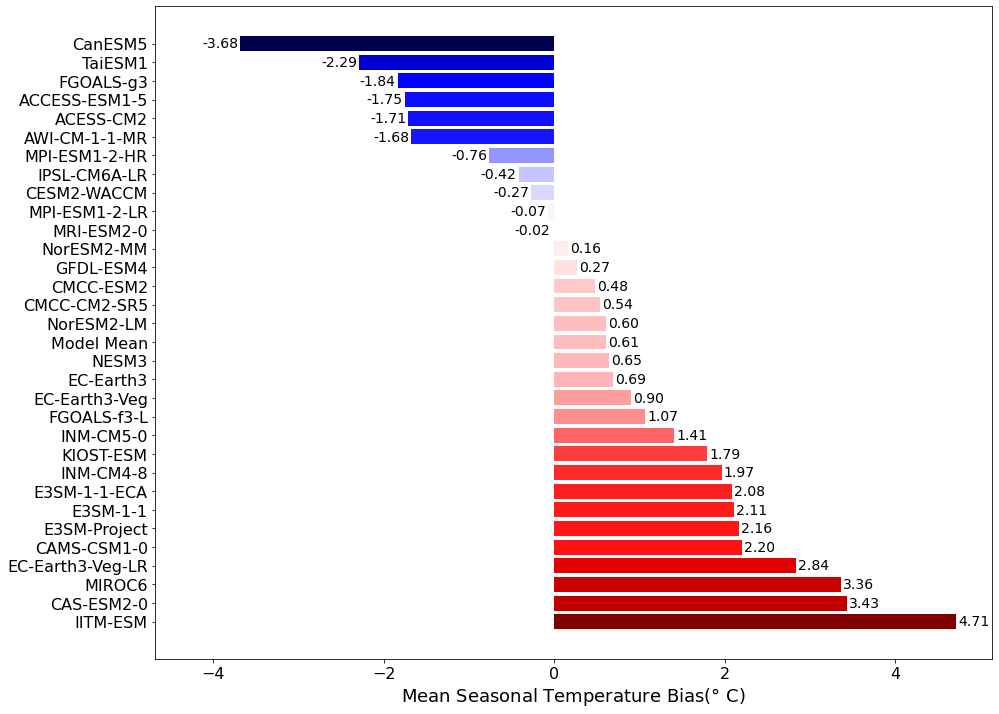

In [6]:
bias_seasonal, bias_sortted = bias_analysis(model_temps_cropped2era5_time,era5_temps[0:63])